## Libraries

In [1]:

import os
import ot
import sys
import time
import torch
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import json
from itertools import zip_longest
import warnings

from tqdm import tqdm
from sklearn.svm import SVC
from torchvision.utils import make_grid
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,accuracy_score ,precision_score, recall_score
from sklearn.metrics import f1_score,confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


from IPython.display import HTML
from matplotlib.animation import FuncAnimation

CONSTANTS

In [2]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18 
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

n_datasets = 6 
n_classes = 7
n_dim = 256
device = 'cpu'
base_path = "assets"

### Read data

In [3]:
def extract_pressure_matrices(json_data):
    pressure_matrices = []
    for entry in json_data['pressureData']:
        pressure_matrix = entry["pressureMatrix"]
        pressure_matrices.append({"pressureMatrix": pressure_matrix})
    return pressure_matrices

def extract_features_from_pressure_matrices(pressure_matrices):
    
    flattened_data = [np.array(item["pressureMatrix"]).reshape(1,-1) for item in pressure_matrices]
    #print(flattened_data[0].shape)
    return np.concatenate(flattened_data, axis=0)

Let's look at the first five subjects first. And say that the sixth has no label, to be our target domain

In [4]:
def process_subjects(data_type):
    true_features = []
    true_labels = []
    Xs, Ys = [], []
    subjects_to_iterate = [1, 2, 3,4,5]

    for subject_id in subjects_to_iterate:
        subject_data = []
        subject_labels = []
        subject_path = os.path.join(base_path, f"Subject_{subject_id}", data_type)

        if data_type == "Continuous_data":
            json_files = [f for f in os.listdir(subject_path) if f.endswith('.json')]
        elif data_type == "Posture_data":
            json_files = [f"Posture_{i}.json" for i in range(1, 8)]
        else:
            raise ValueError("Invalid data type. Choose either 'Continuous_data' or 'Posture_data'.")

        # Loop over each file for the current subject
        for file_name in json_files:
            file_path = os.path.join(subject_path, file_name)

            with open(file_path, 'r') as file:
                json_data = json.load(file)
                pressure_matrices = extract_pressure_matrices(json_data)
                features = extract_features_from_pressure_matrices(pressure_matrices)

                subject_data.append(features)

                if data_type == "Posture_data":
                    posture_label = int(file_name.split("_")[1].split(".")[0])
                    labels = np.full((features.shape[0],), posture_label) # create label vector
                    subject_labels.extend(labels)

        # Create DataFrame for the current subject
        df_features = pd.DataFrame(np.concatenate(subject_data, axis=0)) # X
        X = df_features.values
        true_features.append(X)
        # Converts the generated features and labels into PyTorch tensors
        Xs.append(torch.from_numpy(X).float())
        
        if data_type == "Posture_data":
            df_labels = pd.DataFrame(subject_labels, columns=["Posture"]) # y
            y = np.array(subject_labels)
            # Adjusting the labels to start from 0
            y_adjusted = y - 1
            true_labels.append(y_adjusted)
            Ys.append(torch.nn.functional.one_hot(torch.from_numpy(y_adjusted).long(), num_classes=n_classes).float())

    # Process subject 6 separately : target domain
    subject_id = 6
    subject_data = []
    subject_labels = []
    subject_path = os.path.join(base_path, f"Subject_{subject_id}", data_type)

    if data_type == "Continuous_data":
        json_files = [f for f in os.listdir(subject_path) if f.endswith('.json')]
    elif data_type == "Posture_data":
        json_files = [f"Posture_{i}.json" for i in range(1, 8)]

    for file_name in json_files:
        file_path = os.path.join(subject_path, file_name)

        with open(file_path, 'r') as file:
            json_data = json.load(file)
            pressure_matrices = extract_pressure_matrices(json_data)
            features = extract_features_from_pressure_matrices(pressure_matrices)

            subject_data.append(features)

            if data_type == "Posture_data":
                posture_label = int(file_name.split("_")[1].split(".")[0])
                labels = np.full((features.shape[0],), posture_label)
                subject_labels.extend(labels)

    df_features = pd.DataFrame(np.concatenate(subject_data, axis=0))
    X = df_features.values
    true_features.append(X)
    Xt_tr = torch.from_numpy(X).float()

    if data_type == "Posture_data":
        y = np.array(subject_labels)
        y_adjusted = y - 1
        Yt_tr = torch.nn.functional.one_hot(torch.from_numpy(y_adjusted).long(), num_classes=n_classes).float()
        true_labels.append(y_adjusted)
        return true_features, true_labels, Xs, Ys, Xt_tr, Yt_tr

    return true_features, Xs, Xt_tr

posture_true_features, posture_true_labels, Xs_posture, Ys_posture, Xt_tr_posture, Yt_tr_posture = process_subjects("Posture_data")
posture_datasets = [(Xsk, Ysk) for Xsk, Ysk in zip(Xs_posture, Ys_posture)] + [(Xt_tr_posture, None)]
continuous_true_features, Xs_continuous, Xt_tr_continuous = process_subjects("Continuous_data")


## Data Analysis

We have too little posture data to make a meaningful prediction, we need to collect more data

In [5]:
print(posture_true_features[0].shape) #Features of subject 1
print(posture_true_features[1].shape) #Features of subject 2
print(posture_true_features[2].shape) #Features of subject 3
print(posture_true_features[3].shape) #Features of subject 4
print(posture_true_features[4].shape) #Features of subject 5
print(posture_true_features[5].shape) #Features of subject 6

(349, 256)
(236, 256)
(28951, 256)
(238, 256)
(604, 256)
(13228, 256)


In [6]:
all_data_posture = pd.concat([pd.DataFrame(np.concatenate(posture_true_features, axis=0)), pd.DataFrame(np.concatenate(posture_true_labels, axis=0))], axis=1)

all_data_posture.iloc[:,-1].value_counts()

0
2    6848
0    6353
3    6189
6    6125
4    6102
1    6056
5    5933
Name: count, dtype: int64

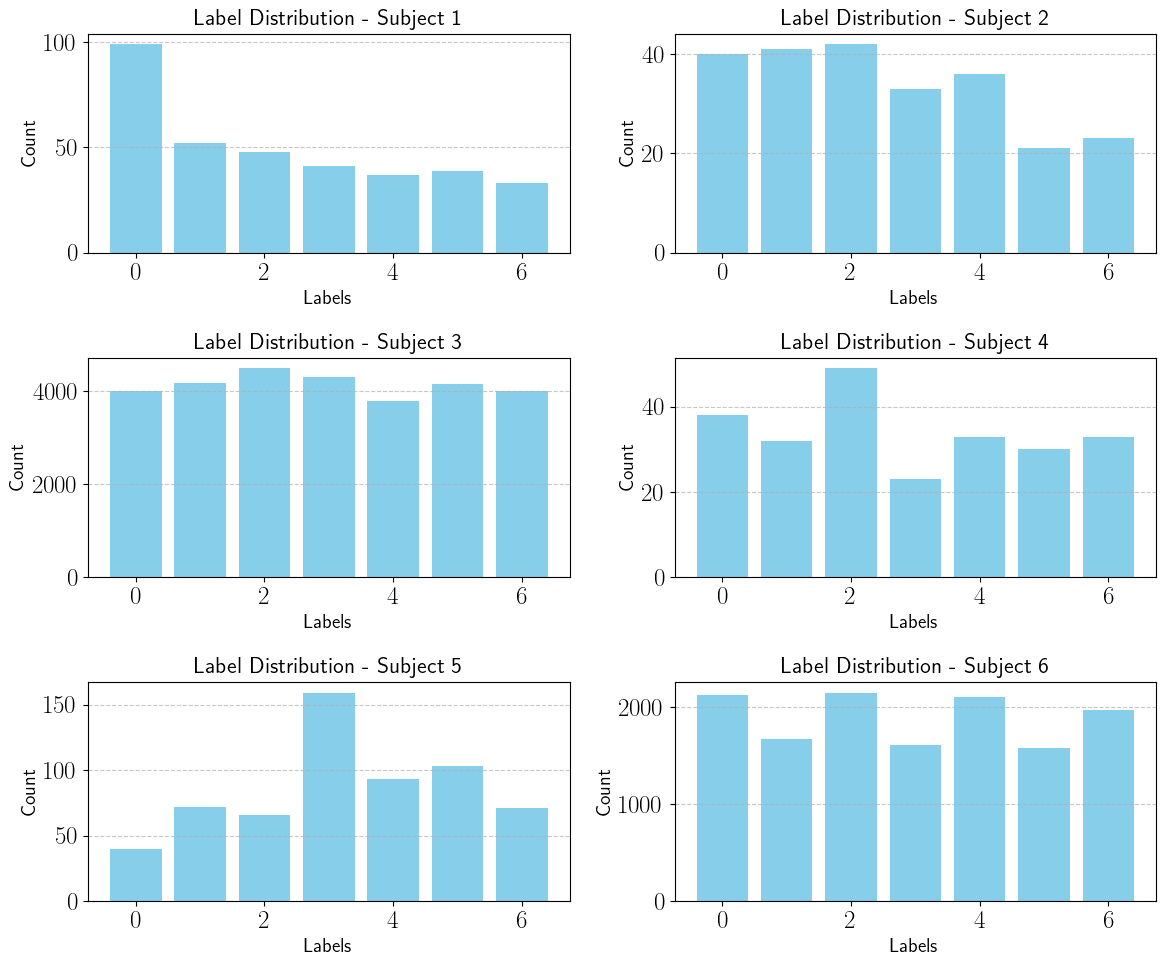

In [7]:
def plot_label_counts(labels, counts, subject_number, ax):
    ax.bar(labels, counts, color='skyblue')
    ax.set_title(f'Label Distribution - Subject {subject_number}', fontsize=16)
    ax.set_xlabel('Labels', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig, axs = plt.subplots(3, 2, figsize=(12, 10))

subject_1_labels, subject_1_counts = np.unique(posture_true_labels[0], return_counts=True)
subject_2_labels, subject_2_counts = np.unique(posture_true_labels[1], return_counts=True)
subject_3_labels, subject_3_counts = np.unique(posture_true_labels[2], return_counts=True)
subject_4_labels, subject_4_counts = np.unique(posture_true_labels[3], return_counts=True)
subject_5_labels, subject_5_counts = np.unique(posture_true_labels[4], return_counts=True)

subject_6_labels, subject_6_counts = np.unique(posture_true_labels[-1], return_counts=True)

subject_labels = [subject_1_labels, subject_2_labels, subject_3_labels, subject_4_labels, subject_5_labels, subject_6_labels]
subject_counts = [subject_1_counts, subject_2_counts, subject_3_counts, subject_4_counts, subject_5_counts, subject_6_counts]

for i in range(6):
    row = i // 2
    col = i % 2
    plot_label_counts(subject_labels[i], subject_counts[i], i+1, axs[row, col])

plt.tight_layout()
plt.show()

Features merge


In [7]:
posture_with_labels = []
data_continuous_concat = []
for posture, labels, continuous in zip(posture_true_features, posture_true_labels, continuous_true_features):
    posture_with_labels.append(pd.concat([pd.DataFrame(posture), pd.DataFrame(labels)], axis=1).values)
    continuous_labels_sample = -1 * np.ones((continuous.shape[0], 1))
    data_continuous_concat.append(pd.concat([pd.DataFrame(continuous), pd.DataFrame(continuous_labels_sample)], axis=1).values)
    
features_merged = [np.concatenate((posture, continuous), axis=0) for posture, continuous in zip(posture_true_features, continuous_true_features)]
features_merged_with_labels = [np.concatenate((posture, continuous), axis=0) for posture, continuous in zip(posture_with_labels, data_continuous_concat)]
    

## Visualization with PCA

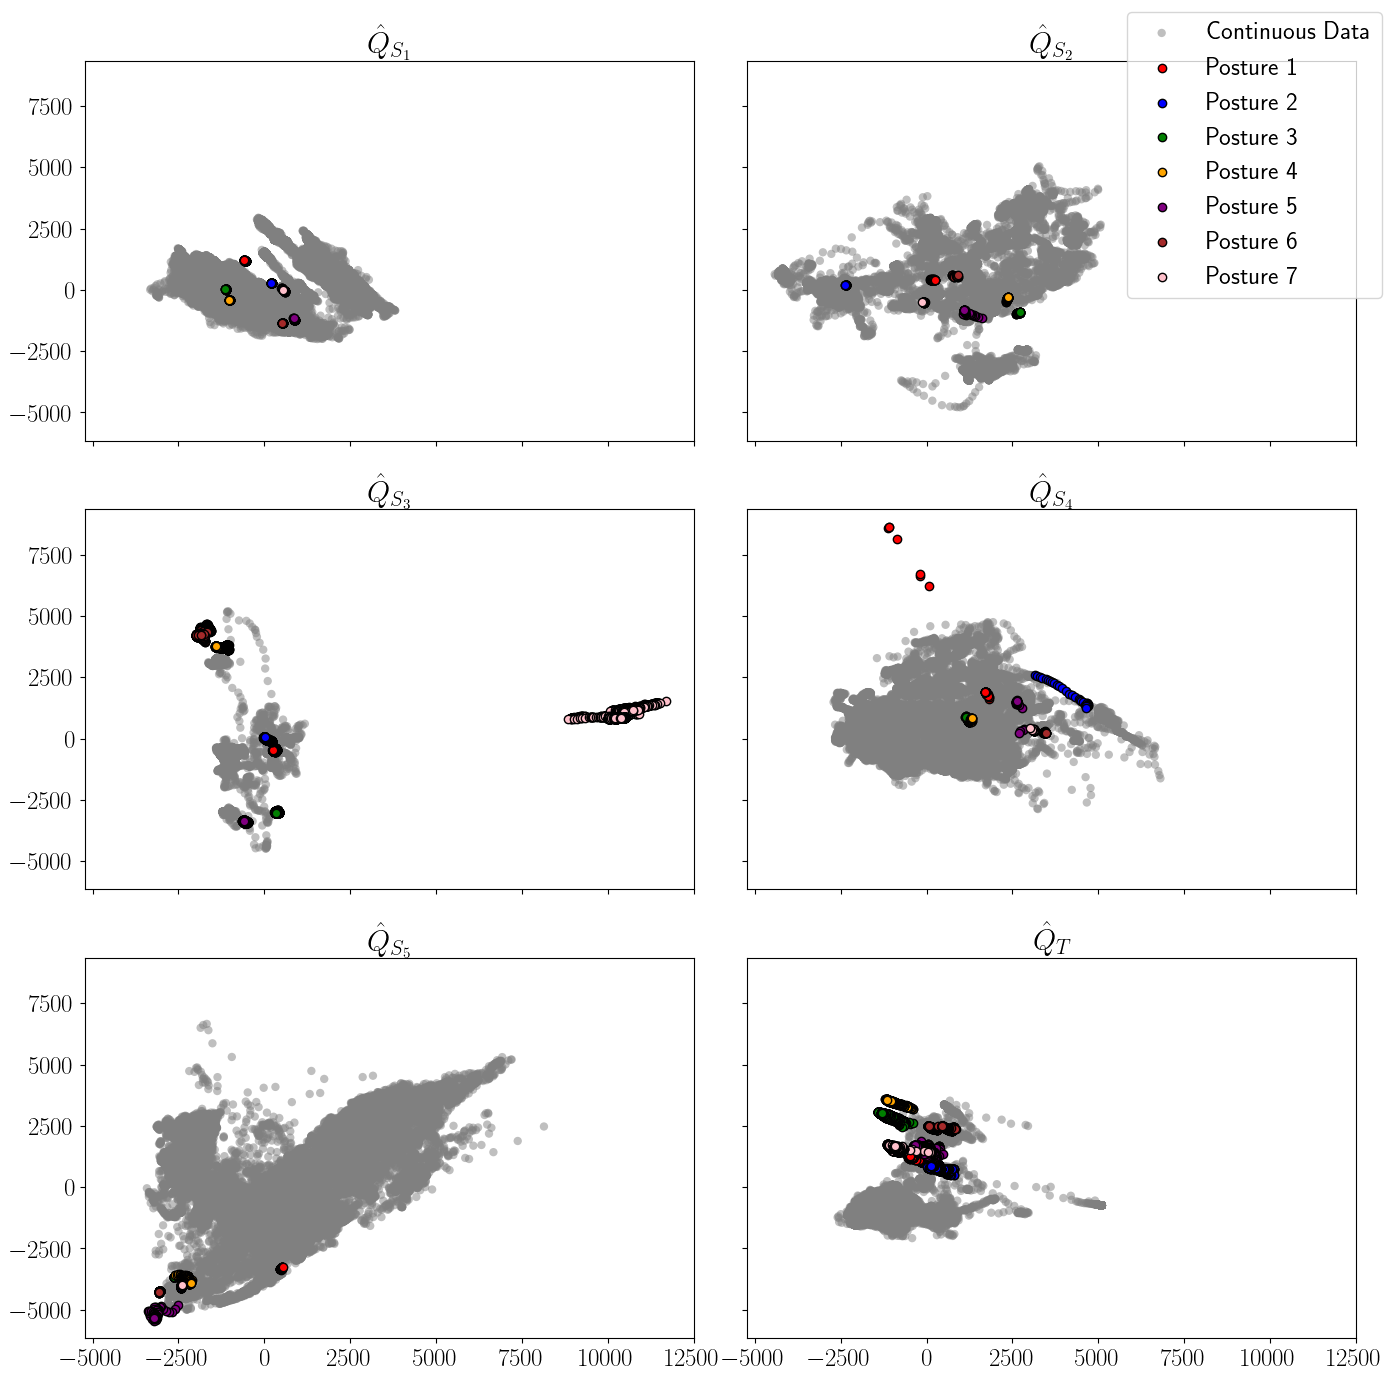

In [44]:
# Plotting
fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharex=True, sharey=True)

# Colors for different postures
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, (Xi, ax) in enumerate(zip(features_merged_with_labels[:-1], axes.flatten()[:-1])):
    Yi = Xi[:,-1]
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Xi[:,:-1])
    
    indices_continuous = np.where(Yi == -1)
    pca_continuous = pca_result[indices_continuous] 
    
    indices_posture = np.where(Yi != -1)
    pca_posture = pca_result[indices_posture]
    
    # Plot continuous data in gray
    ax.scatter(pca_continuous[:, 0], pca_continuous[:, 1], c='gray', alpha=0.5, edgecolor='none', label='Continuous Data')

    # Plot posture data with different colors for each posture
    for j in range(7):  
        indice = np.where(Yi == j)
        ax.scatter(pca_posture[indice, 0], pca_posture[indice, 1], c=colors[j], edgecolor='k', label=f'Posture {j+1}')
    
    
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
    
# Plot the last dataset separately
ax = axes.flatten()[-1]
pca_last = PCA(n_components=2)
pca_result_last = pca_last.fit_transform(features_merged_with_labels[-1][:,:-1]) 

indices_continuous_last = np.where(features_merged_with_labels[-1][:,-1] == -1)
pca_continuous_last = pca_result_last[indices_continuous_last] 

indices_posture_last = np.where(features_merged_with_labels[-1][:,-1] != -1)
pca_posture_last = pca_result_last[indices_posture_last]
    
# Plot continuous data in gray
ax.scatter(pca_continuous_last[:, 0], pca_continuous_last[:, 1], c='gray', alpha=0.5, edgecolor='none', label='Continuous Data')

# Plot posture data with different colors for each posture
for j in range(7):  
    indice = np.where(features_merged_with_labels[-1][:,-1] == j)
    ax.scatter(pca_posture_last[indice, 0], pca_posture_last[indice, 1], c=colors[j], edgecolor='k', label=f'Posture {j+1}')
    
ax.set_title(r"$\hat{Q}_{T}$")

# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

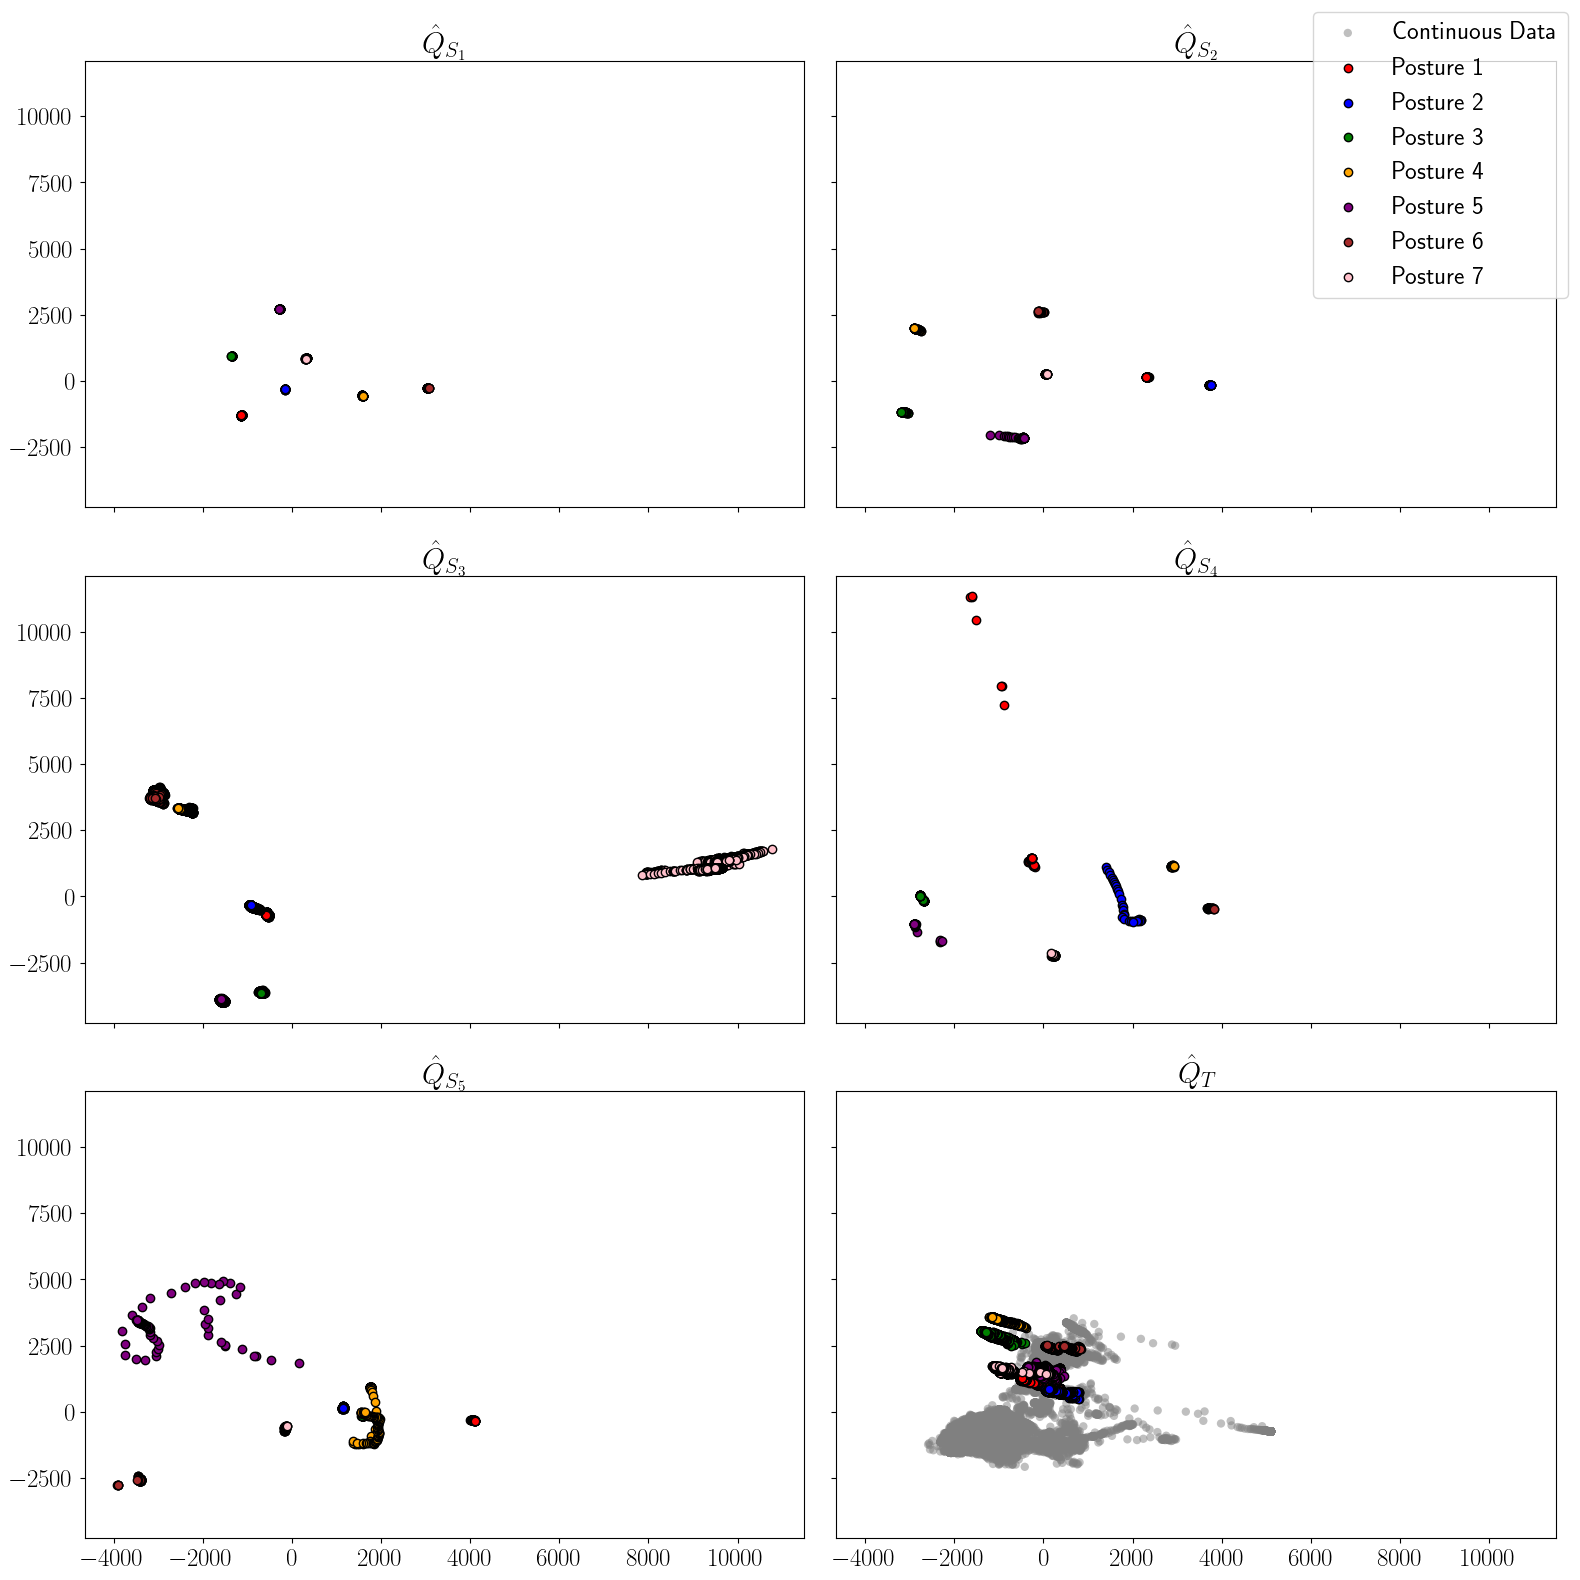

In [45]:
# Plotting
fig, axes = plt.subplots(3, 2, figsize=(16, 16), sharex=True, sharey=True)

# Colors for different postures
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, (Xi, Yi, ax) in enumerate(zip(posture_true_features[:-1], posture_true_labels[:-1], axes.flatten()[:-1])):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Xi)
    # Plot posture data with different colors for each posture
    for j in range(7):  
        indice = np.where(Yi == j)
        ax.scatter(pca_result[indice, 0], pca_result[indice, 1], c=colors[j], edgecolor='k', label=f'Posture {j+1}')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
    
# Plot the last dataset separately
ax = axes.flatten()[-1]
pca_last = PCA(n_components=2)
pca_result_last = pca_last.fit_transform(features_merged_with_labels[-1][:,:-1]) 

indices_continuous_last = np.where(features_merged_with_labels[-1][:,-1] == -1)
pca_continuous_last = pca_result_last[indices_continuous_last] 

indices_posture_last = np.where(features_merged_with_labels[-1][:,-1] != -1)
pca_posture_last = pca_result_last[indices_posture_last]
    
# Plot continuous data in gray
ax.scatter(pca_continuous_last[:, 0], pca_continuous_last[:, 1], c='gray', alpha=0.5, edgecolor='none', label='Continuous Data')

# Plot posture data with different colors for each posture
for j in range(7):  
    indice = np.where(features_merged_with_labels[-1][:,-1] == j)
    ax.scatter(pca_posture_last[indice, 0], pca_posture_last[indice, 1], c=colors[j], edgecolor='k', label=f'Posture {j+1}')
    
ax.set_title(r"$\hat{Q}_{T}$")

# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

# UMAP

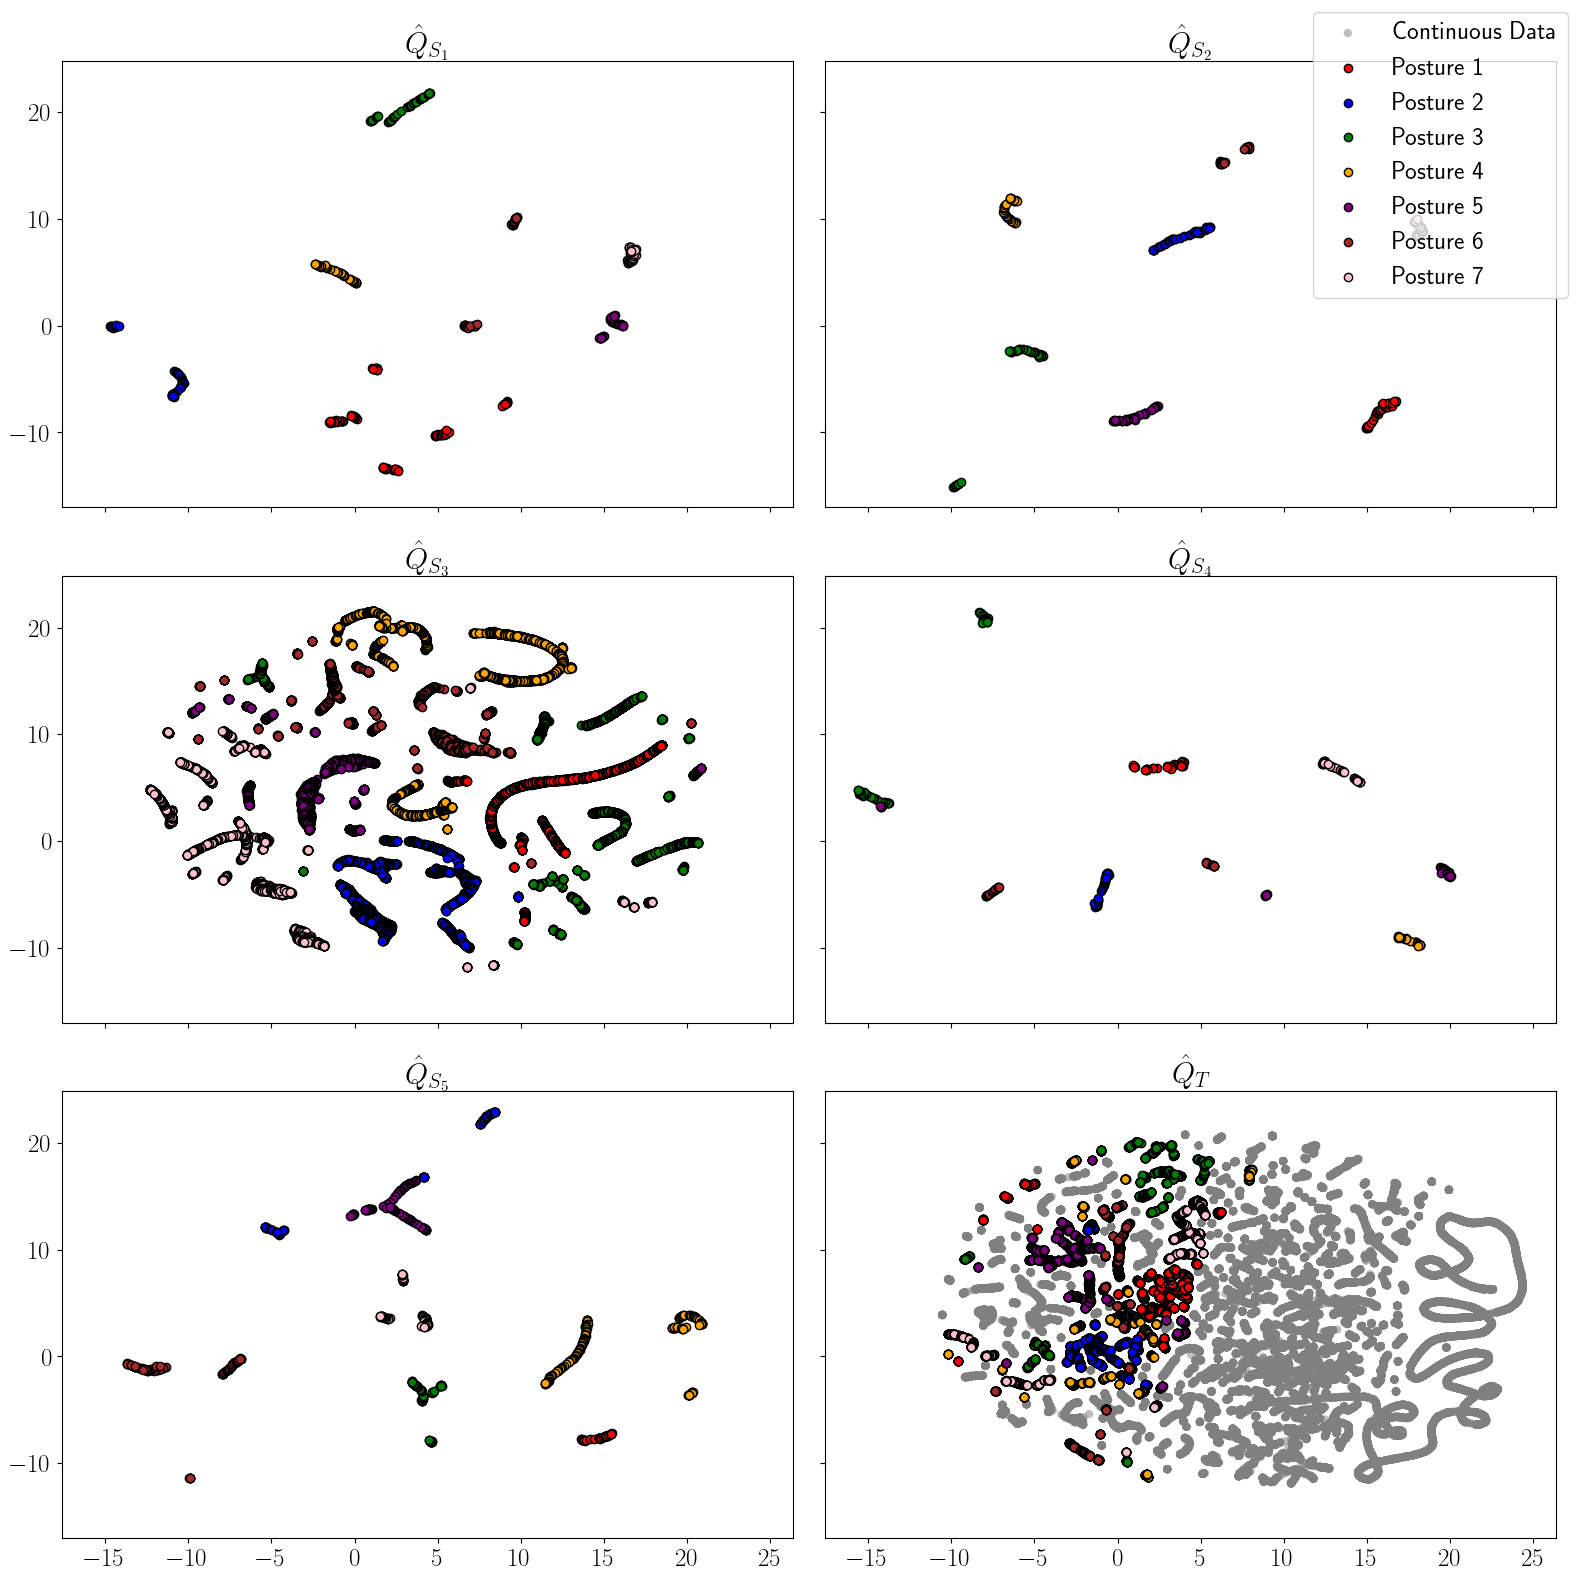

In [46]:
# Plotting
fig, axes = plt.subplots(3, 2, figsize=(16, 16), sharex=True, sharey=True)

# Colors for different postures
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, (Xi, Yi, ax) in enumerate(zip(posture_true_features[:-1], posture_true_labels[:-1], axes.flatten()[:-1])):
    umap_model = umap.UMAP(n_components=2)
    umap_result = umap_model.fit_transform(Xi)
    # Plot posture data with different colors for each posture
    for j in range(7):  
        indice = np.where(Yi == j)
        ax.scatter(umap_result[indice, 0], umap_result[indice, 1], c=colors[j], edgecolor='k', label=f'Posture {j+1}')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")

# Plot the last dataset separately
ax = axes.flatten()[-1]
umap_model = umap.UMAP(n_components=2)
umap_last = umap_model.fit_transform(features_merged_with_labels[-1][:,:-1]) 

indices_continuous_last = np.where(features_merged_with_labels[-1][:,-1] == -1)
umap_continuous_last = umap_last[indices_continuous_last] 

indices_posture_last = np.where(features_merged_with_labels[-1][:,-1] != -1)
umap_posture_last = umap_last[indices_posture_last]
    
# Plot continuous data in gray
ax.scatter(umap_continuous_last[:, 0], umap_continuous_last[:, 1], c='gray', alpha=0.5, edgecolor='none', label='Continuous Data')

# Plot posture data with different colors for each posture
for j in range(7):  
    indice = np.where(features_merged_with_labels[-1][:,-1] == j)
    ax.scatter(umap_posture_last[indice, 0], umap_posture_last[indice, 1], c=colors[j], edgecolor='k', label=f'Posture {j+1}')
    
ax.set_title(r"$\hat{Q}_{T}$")

# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

## K_means + PCA

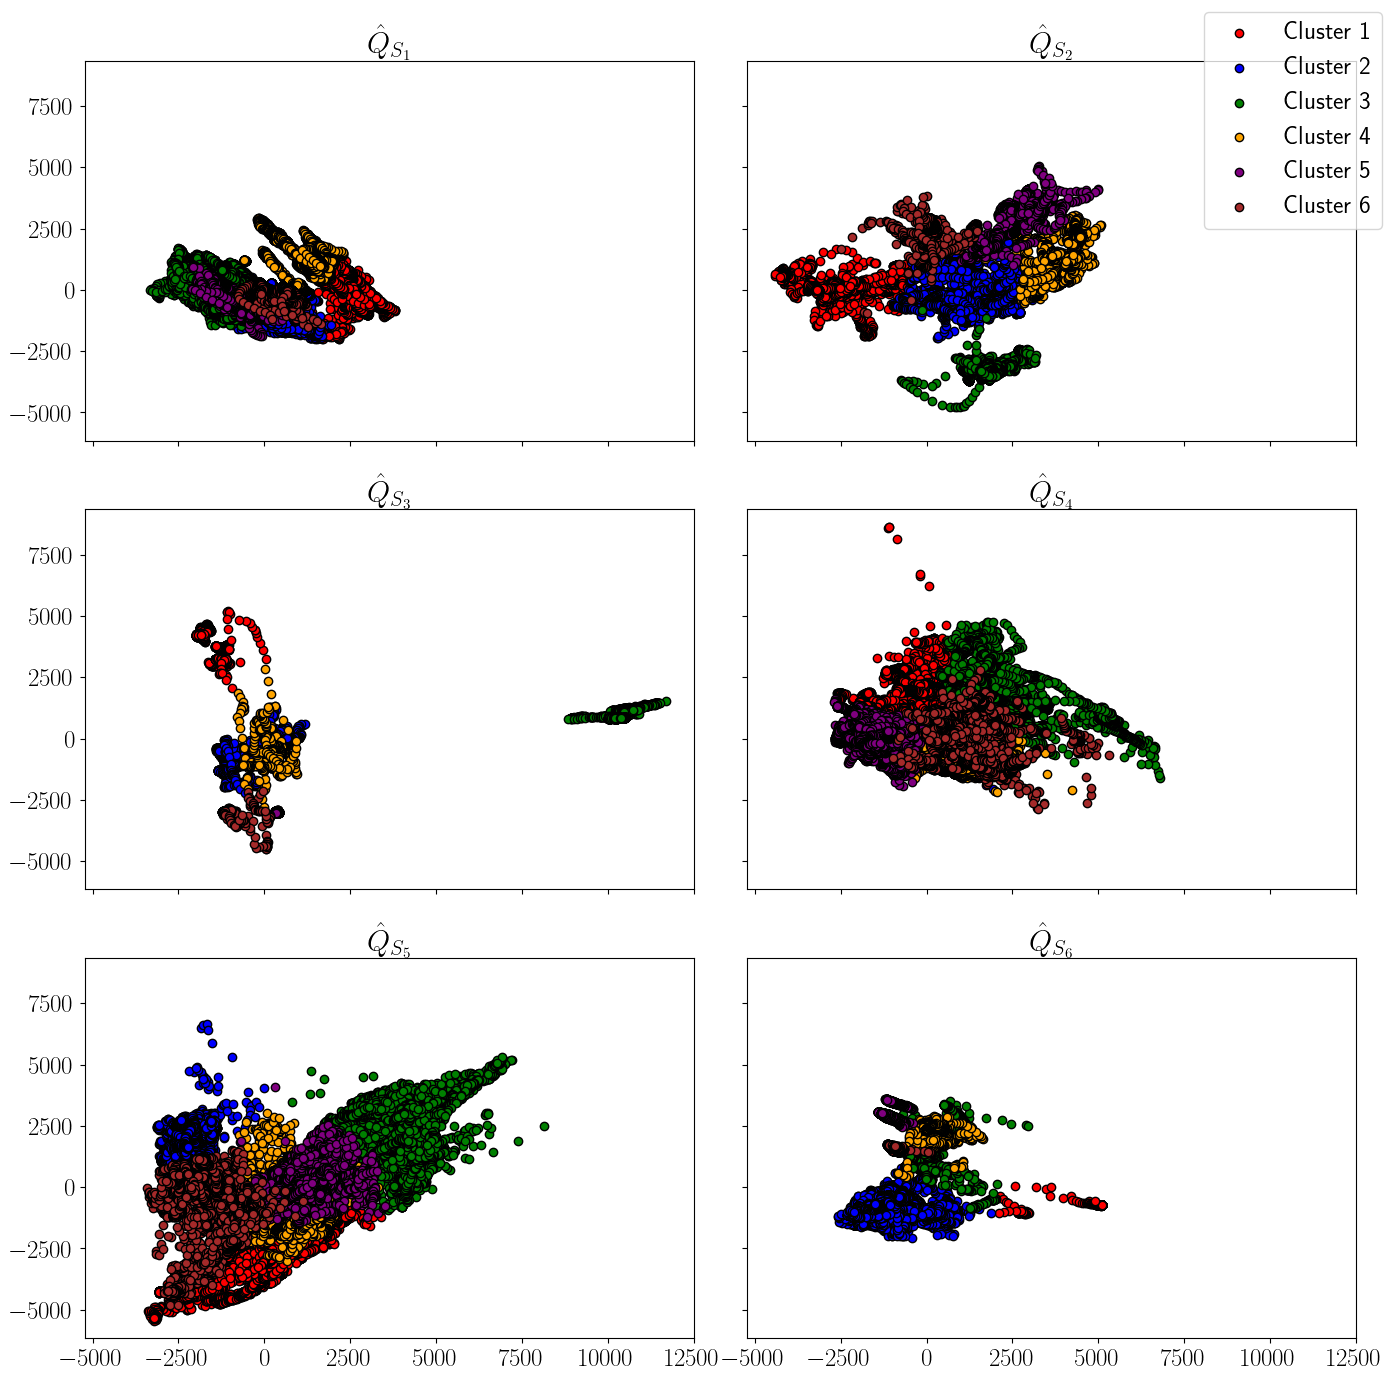

In [47]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# Plotting
fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharex=True, sharey=True)

# Colors for different postures
cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
nb_clusters = [6,6,6,6,6,6]

for i, (Xi, ax) in enumerate(zip(features_merged, axes.flatten())):
    kmeans_posture = KMeans(n_clusters=nb_clusters[i], random_state=1)
    Yi_cluster = kmeans_posture.fit_predict(Xi)
    pca_posture = PCA(n_components=2)
    pca_result_posture = pca_posture.fit_transform(Xi)
    for cluster_id in range(6):  # Assuming 3 clusters
        mask = (Yi_cluster == cluster_id).flatten()
        ax.scatter(pca_result_posture[mask, 0], pca_result_posture[mask, 1], c=cluster_colors[cluster_id], edgecolor='k', label=f'Cluster {cluster_id+1}')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
# Add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

# K means + PCA with controlled data

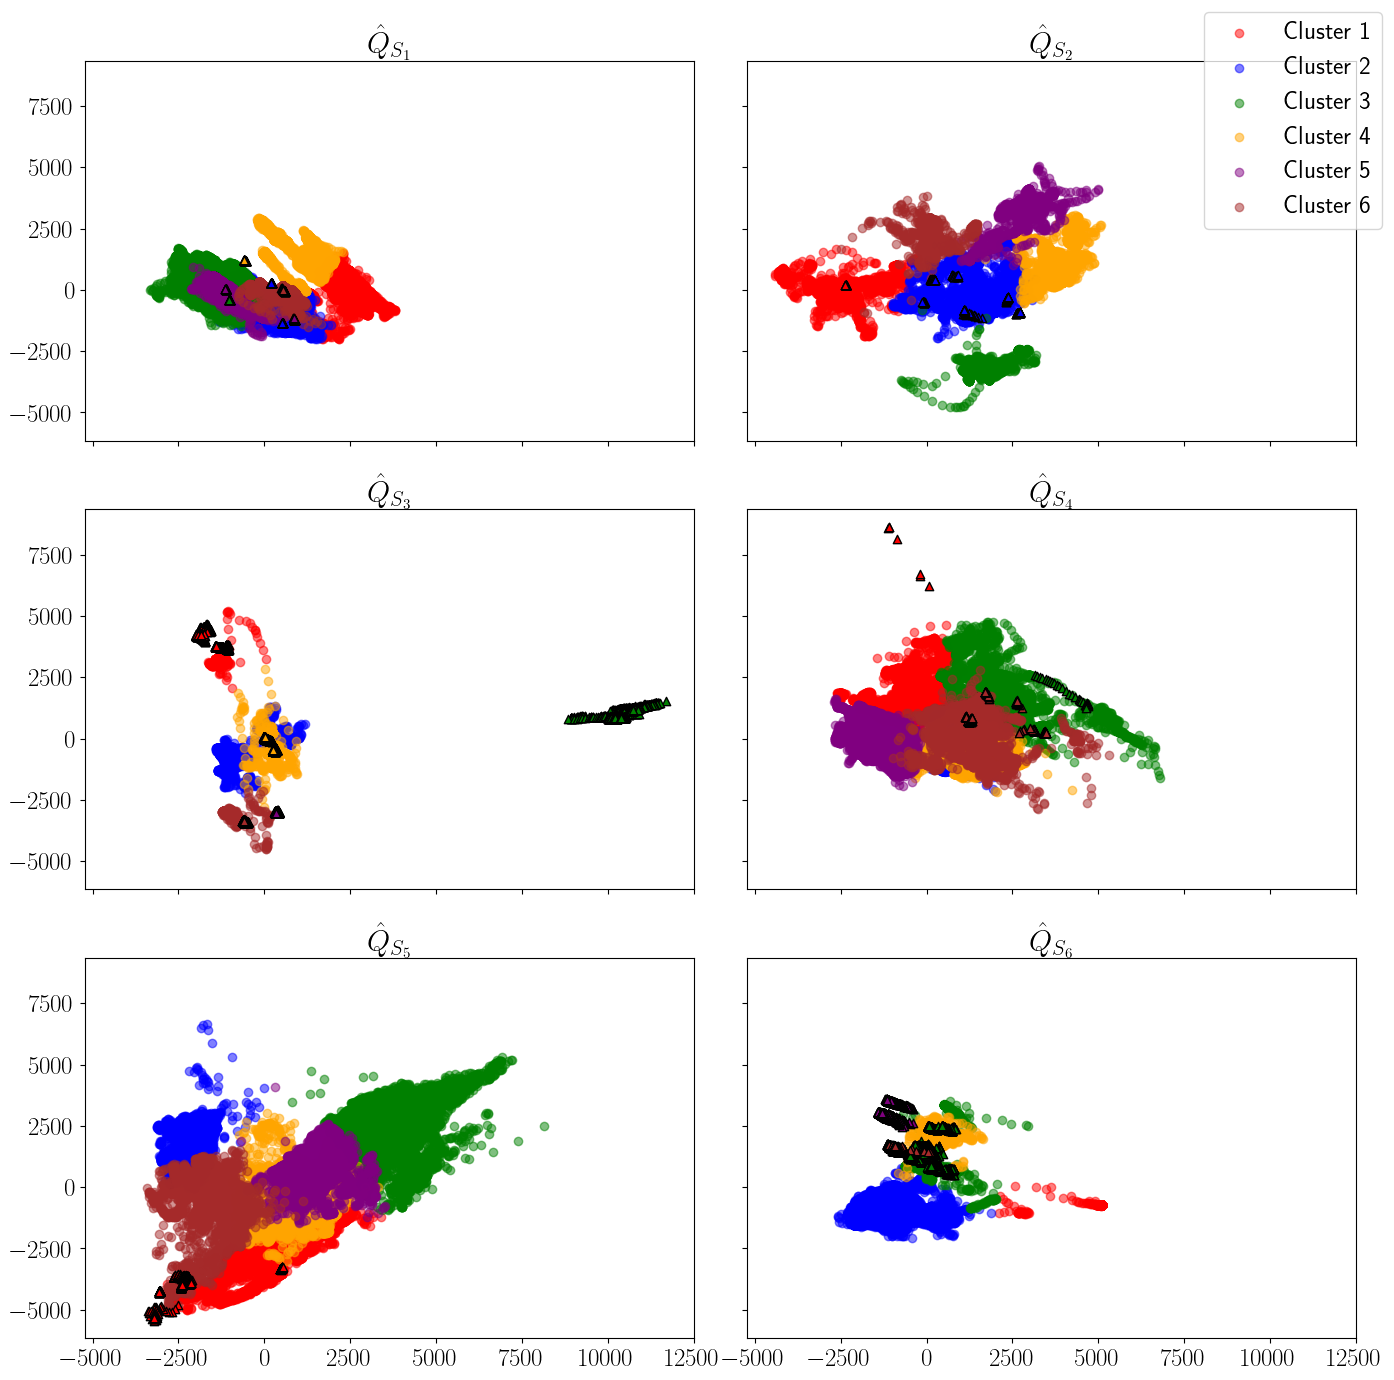

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharex=True, sharey=True)
cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
subjects_titles = [r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$" for i in range(6)] + [r"$\hat{Q}_{T}$"]
nb_clusters = [6,6,6,6,6,6]

# Boucle pour chaque sous-ensemble de données
for i, (Xi, ax) in enumerate(zip(features_merged_with_labels, axes.flatten())):
    kmeans_posture = KMeans(n_clusters=nb_clusters[i], random_state=1)
    Yi = Xi[:, -1]
    Yi_cluster = kmeans_posture.fit_predict(Xi[:, :-1])
    pca_mod = PCA(n_components=2)
    pca_result = pca_mod.fit_transform(Xi[:, :-1])
    
    
    mask_continuous = (Yi == -1)
    pca_continuous = pca_result[mask_continuous]
    Yi_cluster_continuous = Yi_cluster[mask_continuous]    
    for cluster_id in range(nb_clusters[i]) :
        indice = np.where(Yi_cluster_continuous == cluster_id)
        ax.scatter(pca_continuous[indice, 0], pca_continuous[indice, 1], c=cluster_colors[cluster_id], alpha = 0.5, label=f'Cluster {cluster_id+1}')
    
    mask_posture = (Yi != -1)
    pca_posture = pca_result[mask_posture]
    Yi_cluster_posture = Yi_cluster[mask_posture]    
    for cluster_id in range(nb_clusters[i]) :
        indice = np.where(Yi_cluster_posture == cluster_id)
        ax.scatter(pca_posture[indice, 0], pca_posture[indice, 1], c=cluster_colors[cluster_id], edgecolor='k', marker='^', label=f'Cluster {cluster_id+1}')
    
    
    ax.set_title(subjects_titles[i])
    
# Légende unique
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:len(cluster_colors)], labels[:len(cluster_colors)], loc='upper right')
plt.tight_layout()
plt.show()

DBSCAN

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharex=True, sharey=True)
subjects_titles = [r"$\hat{Q}{S{" + str(i + 1) + r"}}$" for i in range(6)] + [r"$\hat{Q}_{T}$"]
epsilon=[1400,1400,900,1200, 1200, 1200]


for i, (Xi, ax) in enumerate(zip(features_merged_with_labels, axes.flatten())):
    eps=epsilon[i]
    pbar = tqdm(total=100, desc="DBSCAN")
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    Xi_scaled = scaler.fit_transform(Xi[:, :-1])
    Xi_scaled=Xi[:, :-1]
    pbar.update(50)
    # Run DBSCAN clustering
    db_posture = DBSCAN(eps, min_samples=5)
    labels = db_posture.fit_predict(Xi_scaled)
    pbar.update(50)
    # Number of clusters in labels, ignoring noise if present
    nb_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, nb_clusters)]
        
    print(f'Dataset {i+1}: {nb_clusters} clusters')

    pbar = tqdm(total=100, desc="PCA")

    Yi = Xi[:, -1]
    pca_mod = PCA(n_components=2)
    pca_result = pca_mod.fit_transform(Xi_scaled)
        
    mask_continuous = (Yi == -1)
    pca_continuous = pca_result[mask_continuous]
    Yi_cluster_continuous = labels[mask_continuous]
        
    mask_posture = (Yi != -1)
    pca_posture = pca_result[mask_posture]
    Yi_cluster_posture = labels[mask_posture]
    pbar.update(100)


    for cluster_id in tqdm(range(nb_clusters), desc='Plot'):
        continuous_indices = np.where(Yi_cluster_continuous == cluster_id)[0]
        posture_indices = np.where(Yi_cluster_posture == cluster_id)[0]
        
        if len(continuous_indices) > 0:
            ax.scatter(pca_continuous[continuous_indices, 0], pca_continuous[continuous_indices, 1], 
                        color=colors[cluster_id], alpha=0.5, label=f'Cluster {cluster_id+1}',zorder=1)
            
        if len(posture_indices) > 0:
            ax.scatter(pca_posture[posture_indices, 0], pca_posture[posture_indices, 1], 
                        color=colors[cluster_id], edgecolor='k', marker='^', label=f'Cluster {cluster_id+1}', zorder=2)
        
        ax.set_title(subjects_titles[i]+' avec '+str(nb_clusters-7)+' clusters (hors des postures controlées)')
        # Single legend
        handles, labels = axes[0, 0].get_legend_handles_labels()
        #ax.legend(handles[:nb_clusters], labels[:nb_clusters], loc='upper right')
        


plt.tight_layout()
plt.show()

DBSCAN:  50%|█████     | 50/100 [00:21<00:01, 36.87it/s]

: 

## Wasserstein Barycenters


In [8]:
def wasserstein_barycenter(XP, # atom
                           YP=None, # atom label
                           XB=None, # initial guess for the barycenter
                           YB=None, #labels of the initial guess for the barycenter
                           weights=None,
                           n_samples=None, #number of atoms
                           n_iter_max=10,
                           tol=1e-9, #Tolerance for convergence.
                           verbose=False,
                           inner_verbose=False,
                           propagate_labels=False,
                           penalize_labels=False):
    if n_samples is None and XB is None:
        # If number of points is not provided,
        # assume that the support of the barycenter has sum(nsi) where si is the i-th source domain.
        n_samples = int(np.sum([len(XPk) for XPk in XP]))
    
    if YP is None:
        if propagate_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                             " for 'propagate_labels' = True"))
        if penalize_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                              " for 'penalize_labels' = True"))
    else:
        n_classes = YP[0].shape[1]
    #Initialization of data types, device, and weights.
    dtype = XP[0].dtype
    device = XP[0].device

    if weights is None:
        weights = (torch.ones(len(XP)) / len(XP)).to(dtype).to(device)

    it = 0
    comp_start = time.time()

    # Initializes Features
    if XB is None:
        XB = torch.randn(n_samples, XP[0].shape[1])

    # Initializes Labels
    if YB is None:
        yB = torch.from_numpy(
            np.random.randint(low=0,
                              high=n_classes,
                              size=n_samples)).long()
        YB = torch.nn.functional.one_hot(
            yB, num_classes=n_classes).float()

    # Displacement of points in the support
    delta = tol + 1
    last_loss = np.inf
    # Create uniform weights
    u_P = [torch.ones(len(XPk), device=device) / len(XPk) for XPk in XP]
    u_B = torch.ones(len(XB), device=device) / len(XB)

    #Sinkhorn algorithm iterates until convergence or reaching the maximum number of iterations.
    while (delta > tol and it < n_iter_max):
        # NOTE: Here we solve the barycenter problem without calculating
        # gradients at each iteration, as per the envelope theorem, we
        # only need to compute gradients at optimality.
        with torch.no_grad():
            C, ot_plans = [], []

            for k in range(len(XP)):
                C_k = torch.cdist(XP[k], XB, p=2) ** 2
                if penalize_labels:
                    C_k += C_k.detach().max() * torch.cdist(YP[k], YB, p=2) ** 2
                plan_k = ot.emd(u_P[k], u_B, C_k)
                C.append(C_k)
                ot_plans.append(plan_k.to(dtype))
            XB = sum([
                w_k * n_samples * torch.mm(plan_k.T, XP_k)
                for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
            ])
            if propagate_labels:
                YB = sum([
                    w_k * n_samples * torch.mm(plan_k.T, YP_k)
                    for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
                ])
            loss = sum([
                torch.sum(C_k * plan_k) for C_k, plan_k in zip(C, ot_plans)
            ])
            delta = torch.norm(loss - last_loss) / n_samples
            last_loss = loss

            it += 1
    # Re-evaluate the support at optimality for calculating the gradients
    # NOTE: now we define the support while holding its gradients w.r.t. the
    # weight vector and eventually the support.
    XB = sum([
        w_k * n_samples * torch.mm(plan_k.T, XP_k)
        for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
    ])
    if propagate_labels:
        YB = sum([
            w_k * n_samples * torch.mm(plan_k.T, YP_k)
            for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
        ])
        return XB, YB
    return XB

## Dictionary Learning


### Hyper Parameters

In [9]:
lr = 1e-1 #Learning rate for optimization.
n_iter_max = 40 #Maximum number of iterations for training.
n_samples = 1022
#n_samples = min(len(X) for X in true_features) 
batch_size = 128
n_components = 5 
batches_per_it = n_samples // batch_size
spc = n_samples // n_classes
spc_batches = batch_size // n_classes

### Optimization variables definition

In [10]:
XP = torch.nn.ParameterList([  #. Each component is a 256D tensor.
    torch.nn.parameter.Parameter(data=torch.randn(n_samples, 256), requires_grad=True)
    for _ in range(n_components)
])

YP_init = []
for _ in range(n_components):
    ypk = torch.cat(
        [torch.tensor([c] * spc)
         for c in range(n_classes)]
    ).long()
    YPk = torch.nn.functional.one_hot(ypk,
                                      num_classes=n_classes)
    YP_init.append(YPk)
    
YP = torch.nn.ParameterList([       
    torch.nn.parameter.Parameter(data=yp.float(),
                                 requires_grad=True)
    for yp in YP_init]
)

A0 = torch.ones(n_datasets, n_components) / n_components

A = torch.nn.parameter.Parameter(data=A0, requires_grad=True) # barycentric weight matrice

optimizer = torch.optim.Adam([*XP, *YP, A], lr=lr)

### Loss Definition

In [11]:
class JointWassersteinDistance(torch.nn.Module):
    def __init__(self):
        super(JointWassersteinDistance, self).__init__()

    def forward(self, XQ, YQ, XP, YP, index=None):
        # ces masses sont uniformes, la meme masse pour chaque sample
        # a plus faible a des postures inconnus
        a = torch.ones(XP.shape[0], device=XP.device) / XP.shape[0] # a = poids (masses) de la premiere distribuition affectes a chachun des samples
        b = torch.ones(XQ.shape[0], device=XQ.device) / XQ.shape[0]
        CX = torch.cdist(XP, XQ, p=2) ** 2

        if YP is not None and YQ is not None:
            CY = torch.cdist(YP, YQ, p=2) ** 2
        else:
            CY = torch.zeros_like(CX)

        label_weight = CX.detach().max()

        C = CX + label_weight * CY
        with torch.no_grad():
            # NOTE: We DO NOT backpropagate through
            #       the OT plan.
            plan = ot.emd(a, b, C) #it computes the optimal transport plan for the given cost matrix C.
            # a = poids de la premiere distribuition
            #
            #c = matrice de distance entre a et b
        return torch.sum(C * plan)
    
criterion = JointWassersteinDistance()

### Learning Loop

In [12]:
fit_history = {
    'weights': [],
    'loss': [],
    'atoms_features': [],
    'atoms_labels': []
}

for it in range(n_iter_max):
    pbar = tqdm(range(batches_per_it))
    avg_it_loss = 0.0
    for _ in pbar:
        optimizer.zero_grad()
        
        loss = 0.0
        for l, ((XQl, YQl), al) in enumerate(zip(posture_datasets, A)):
            # Samples a minibatch from XQl
            if YQl is None:
                indices = np.random.choice(np.arange(len(XQl)), size=batch_size)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = None
            else:
                yQl = YQl.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yQl == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = YQl[indices]
                
            # Samples a minibatch from each XP
            minibatch_XP = []
            minibatch_YP = []
            for XPk, YPk in zip(XP, YP):
                yPk = YPk.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yPk == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                
                minibatch_XP.append(XPk[indices])
                minibatch_YP.append(YPk[indices].softmax(dim=1))
                
            # Calculates a Wasserstein Barycenter
            minibatch_XBl, minibatch_YBl = wasserstein_barycenter(
                XP=minibatch_XP,#atoms en entré
                YP=minibatch_YP,
                XB=None,
                YB=None,
                weights=al,
                n_samples=batch_size,
                n_iter_max=10,
                tol=1e-9,
                verbose=False,
                inner_verbose=False,
                propagate_labels=True,
                penalize_labels=True)
            
            #erreur d'approximation
            loss_l = criterion(minibatch_XQl, 
                               minibatch_YQl,
                               minibatch_XBl,
                               minibatch_YBl)
            loss += loss_l
        # Backprop
        loss.backward()
        
        # Optimization Step
        optimizer.step() #mettre a jour les atoms et les poids pour reduire l'approximation
        
        # project weights back into the simplex
        with torch.no_grad():
            A.data = ot.utils.proj_simplex(A.data.T).T
        
        # Save it for logging
        avg_it_loss += loss.item() / batches_per_it
    # Save vars for plotting
    fit_history['weights'].append(A.data.detach().clone())
    fit_history['loss'].append(avg_it_loss)
    fit_history['atoms_features'].append([XPk.data.detach().clone() for XPk in XP])
    fit_history['atoms_labels'].append([YPk.data.detach().clone() for YPk in YP])
    print(f'It {it} our of {n_iter_max}. Loss: {avg_it_loss}')

100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


It 0 our of 40. Loss: 634935808.0


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


It 1 our of 40. Loss: 510552690.2857144


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


It 2 our of 40. Loss: 414180278.8571428


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


It 3 our of 40. Loss: 373830633.14285713


100%|██████████| 7/7 [00:23<00:00,  3.41s/it]


It 4 our of 40. Loss: 357934998.85714287


100%|██████████| 7/7 [00:23<00:00,  3.36s/it]


It 5 our of 40. Loss: 350658011.4285714


100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


It 6 our of 40. Loss: 347345860.57142854


100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


It 7 our of 40. Loss: 347965654.85714287


100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


It 8 our of 40. Loss: 345263972.57142854


100%|██████████| 7/7 [00:24<00:00,  3.48s/it]


It 9 our of 40. Loss: 344910532.57142854


100%|██████████| 7/7 [00:24<00:00,  3.45s/it]


It 10 our of 40. Loss: 346954665.1428572


100%|██████████| 7/7 [00:24<00:00,  3.43s/it]


It 11 our of 40. Loss: 344151350.8571428


100%|██████████| 7/7 [00:23<00:00,  3.41s/it]


It 12 our of 40. Loss: 343681572.57142854


100%|██████████| 7/7 [00:23<00:00,  3.32s/it]


It 13 our of 40. Loss: 343049462.8571428


100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


It 14 our of 40. Loss: 342622313.14285713


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


It 15 our of 40. Loss: 343483757.71428573


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


It 16 our of 40. Loss: 342128288.00000006


100%|██████████| 7/7 [00:14<00:00,  2.11s/it]


It 17 our of 40. Loss: 341391049.14285713


100%|██████████| 7/7 [00:14<00:00,  2.12s/it]


It 18 our of 40. Loss: 341161888.0


100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


It 19 our of 40. Loss: 341101956.5714286


100%|██████████| 7/7 [00:14<00:00,  2.14s/it]


It 20 our of 40. Loss: 341185110.85714287


100%|██████████| 7/7 [00:16<00:00,  2.31s/it]


It 21 our of 40. Loss: 337580512.00000006


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


It 22 our of 40. Loss: 338179771.4285714


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


It 23 our of 40. Loss: 339307986.28571427


100%|██████████| 7/7 [00:15<00:00,  2.21s/it]


It 24 our of 40. Loss: 337643081.14285713


100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


It 25 our of 40. Loss: 337139158.85714287


100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


It 26 our of 40. Loss: 338171597.71428573


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


It 27 our of 40. Loss: 336521165.7142857


100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


It 28 our of 40. Loss: 336222660.57142854


100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


It 29 our of 40. Loss: 333551821.71428573


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


It 30 our of 40. Loss: 336933636.57142854


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


It 31 our of 40. Loss: 334727200.0


100%|██████████| 7/7 [00:14<00:00,  2.03s/it]


It 32 our of 40. Loss: 333259392.0


100%|██████████| 7/7 [00:22<00:00,  3.25s/it]


It 33 our of 40. Loss: 334747634.28571427


100%|██████████| 7/7 [00:22<00:00,  3.27s/it]


It 34 our of 40. Loss: 332711168.00000006


100%|██████████| 7/7 [00:26<00:00,  3.80s/it]


It 35 our of 40. Loss: 334496416.0


100%|██████████| 7/7 [00:20<00:00,  2.98s/it]


It 36 our of 40. Loss: 333362683.4285714


100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


It 37 our of 40. Loss: 332974912.0


100%|██████████| 7/7 [00:22<00:00,  3.25s/it]


It 38 our of 40. Loss: 332092649.14285713


100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


It 39 our of 40. Loss: 330495488.0


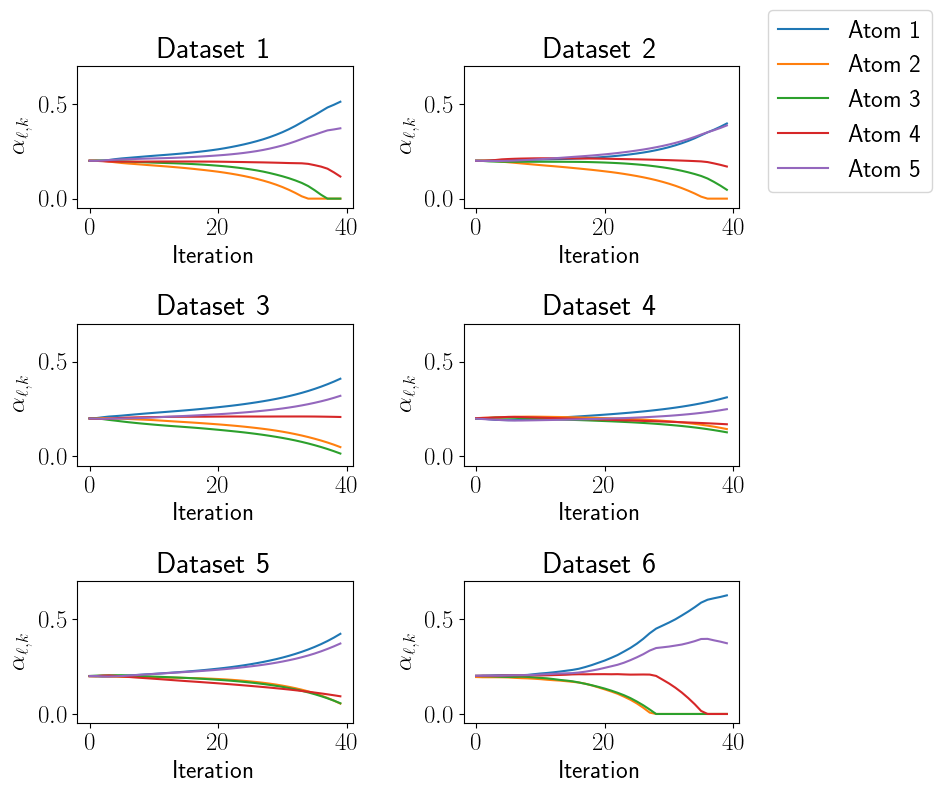

In [19]:
whist = torch.stack(fit_history['weights'])

fig, axes = plt.subplots(3, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    for k in range(n_components):
        ax.plot(whist[:, i, k], label=f'Atom {k + 1}'.format(k + 1))
    ax.set_title(f'Dataset {i + 1}')
    #ax.set_ylim([0.31, 0.36])
    ax.set_ylim([-0.05, 0.7])
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.20, 1), borderaxespad=0.)

axes[0, 0].set_ylabel(r'$\alpha_{\ell,k}$')
axes[0, 0].set_xlabel('Iteration')

axes[1, 0].set_ylabel(r'$\alpha_{\ell,k}$')
axes[1, 0].set_xlabel('Iteration')

axes[2, 0].set_ylabel(r'$\alpha_{\ell,k}$')
axes[2, 0].set_xlabel('Iteration')

axes[0, 1].set_ylabel(r'$\alpha_{\ell,k}$')
axes[0, 1].set_xlabel('Iteration')

axes[1, 1].set_ylabel(r'$\alpha_{\ell,k}$')
axes[1, 1].set_xlabel('Iteration')

axes[2, 1].set_ylabel(r'$\alpha_{\ell,k}$')
axes[2, 1].set_xlabel('Iteration')
plt.tight_layout()

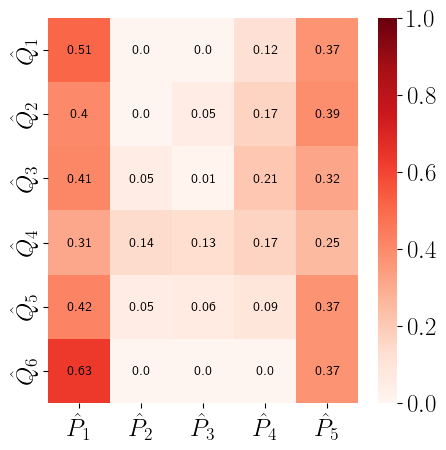

In [14]:
XP = [XPk.detach() for XPk in XP]
YP = [YPk.detach() for YPk in YP]
A = A.detach()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.heatmap(np.round(A, 2), cmap='Reds', ax=ax, vmin=0, vmax=1, cbar=True)
_ = ax.set_yticks([i + .5 for i in range(len(posture_true_features))],
                  [r"$\hat{Q}_{" + str(i + 1) + "}$" for i in range(len(posture_true_features))])
_ = ax.set_xticks([i + .5 for i in range(len(XP))],
                  [r"$\hat{P}_{" + str(i + 1) + "}$" for i in range(len(XP))])

for i in range(len(posture_true_features)):
    for j in range(len(XP)):
        ax.text(j + 0.5, i + 0.5, str(np.round(A[i, j].item(), 2)), ha='center', va='center', fontsize=10)

# Dadil - E : Obtain a customized classifier for a target subject whose data has not been used to learn atoms.

we can fit a classifier on each atom, that is, we find,
$$\hat{h}_{k} = \text{argmin}_{h\in\mathcal{H}}\hat{\mathcal{R}}_{P_{k}}(h)$$

In [20]:
warnings.filterwarnings('ignore')
XP = [XPk.detach() for XPk in XP]
YP = [YPk.detach() for YPk in YP]
A = A.detach()

# Define models and hyperparameter grids
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Support Vector Machine': SVC(class_weight='balanced', kernel='rbf', probability=True),
    'Gradient Boosting': GradientBoostingClassifier()
}

param_grids = {
    'Logistic Regression': {'model__C': [0.1, 1, 10]},
    'Decision Tree': {'model__max_depth': [10]},
    'Random Forest': {'model__n_estimators': [100]},
    'Support Vector Machine': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale']},
    'Gradient Boosting': {'model__n_estimators': [100], 'model__learning_rate': [0.1]}
}

classifiers = []
model_predictions = {model_name: [] for model_name in models.keys()}
model_metrics = []
y_pred = {}

X_test = posture_true_features[-1]
y_test = posture_true_labels[-1]

for X_atom, Y_atom in zip(XP, YP):
    y_atom = Y_atom.argmax(axis=1)
    
    for model_name, model in models.items():
        # Create pipeline with scaler and model
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()), # Normalization step
            ('model', model)
        ])
        
        # Hyperparameter tuning with GridSearchCV
        param_grid = param_grids[model_name]
        grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted',n_jobs=-1, n_iter=10, verbose=1)
        grid_search.fit(X_atom, y_atom)
        best_model = grid_search.best_estimator_
        
        # Add the trained model to the list of classifiers
        classifiers.append(best_model)
        
        # Evaluate the model on the test set
        y_pred = best_model.predict_proba(X_test)
        model_predictions[model_name].append(y_pred)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalli

Naturally, one may use $\alpha \in \Delta_{K}$ for weighting predictions of atom classifiers. We weight the $\hat{h}_{k}$'s using $\alpha_{T}$, which gives,

$$\hat{h}_{E}(\mathbf{x}^{(Q_{T})}_{j})=\sum_{k=1}^{K}\alpha_{T,k}\hat{h}_{k}(\mathbf{x}_{j}^{(Q_{T})}),$$

In [22]:
# Function to aggregate predictions and print classification report
def aggregate_and_report(model_name, model_predictions, A, y_test):
    # Aggregate predictions using the weights from A
    y_pred_final = sum(A[-1, i].item() * model_predictions[model_name][i] for i in range(len(model_predictions[model_name])))
    
    # Predict the class with the highest probability
    y_pred = y_pred_final.argmax(axis=1)
    
    # Print the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

# List of model names to iterate over
model_names = ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'Support Vector Machine']

# Iterate over each model name and generate the report
for model_name in model_names:
    aggregate_and_report(model_name, model_predictions, A, y_test)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2129
           1       0.00      0.00      0.00      1678
           2       0.00      0.00      0.00      2149
           3       0.00      0.00      0.00      1616
           4       1.00      0.01      0.02      2110
           5       0.14      1.00      0.24      1579
           6       0.00      0.00      0.00      1967

    accuracy                           0.12     13228
   macro avg       0.16      0.14      0.04     13228
weighted avg       0.18      0.12      0.03     13228

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2129
           1       0.00      0.00      0.00      1678
           2       0.00      0.00      0.00      2149
           3       0.45      1.00      0.62      1616
           4       0.00      0.00      0

# Continuous data

In [24]:
print(continuous_true_features[0].shape) #Features of subject 1
print(continuous_true_features[1].shape) #Features of subject 2
print(continuous_true_features[2].shape) #Features of subject 3
print(continuous_true_features[3].shape) #Features of subject 4
print(continuous_true_features[4].shape) #Features of subject 5
print(continuous_true_features[5].shape) #Features of subject 6

(172984, 256)
(70093, 256)
(29555, 256)
(107954, 256)
(125315, 256)
(47452, 256)
